In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary

In [22]:
data = pd.read_csv("/Users/veera/Data/Repos/Udemy/.dataset/mnist_train.csv", delimiter=',', header=None)

In [23]:
labels = data[0]
data = data.drop(columns=[0])

In [24]:
data = np.array(data)
labels = np.array(labels)

In [25]:
# The min and max values of the data are 0 and 255
# It is normalized to 0 and 1
data_norm = data/np.max(data)

## Tensor dataset and loader

In [26]:
data_tensor = torch.tensor(data_norm).float()
label_tensor = torch.tensor(labels).long()

In [27]:
data_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [28]:
label_tensor

tensor([5, 0, 4,  ..., 5, 6, 8])

In [38]:
x_train, x_test, y_train, y_test = train_test_split(data_tensor, label_tensor, train_size=0.7, stratify=label_tensor)

In [39]:
x_train.shape

torch.Size([42000, 784])

In [40]:
y_train.shape

torch.Size([42000])

In [41]:
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

In [42]:
train_data.tensors

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([8, 4, 3,  ..., 4, 6, 2]))

In [43]:
test_data.tensors

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 4, 1,  ..., 0, 0, 8]))

In [44]:
train_loader = DataLoader(train_data, batch_size=64, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [45]:
for i in test_loader:
    print(i[0].shape, i[1].shape)

torch.Size([18000, 784]) torch.Size([18000])


In [46]:
%whos

Variable           Type             Data/Info
---------------------------------------------
DataLoader         type             <class 'torch.utils.data.dataloader.DataLoader'>
F                  module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset      type             <class 'torch.utils.data.dataset.TensorDataset'>
data               ndarray          60000x784: 47040000 elems, type `int64`, 376320000 bytes (358.88671875 Mb)
data_norm          ndarray          60000x784: 47040000 elems, type `float64`, 376320000 bytes (358.88671875 Mb)
data_tensor        Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
i                  list             n=2
label_tensor       Tensor           tensor([5, 0, 4,  ..., 5, 6, 8])
labels             ndarray          60000: 60000 elems, type `int64`, 480000 bytes (468.75 kb)
nn                 module           <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
np                 module         

## Model

In [47]:
def create_model():
    class ann(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784, 32)
            self.hidden1 = nn.Linear(32, 64)
            self.hidden2 = nn.Linear(64, 64)
            self.output = nn.Linear(64, 10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            x = F.relu(self.output(x))
            return torch.log_softmax(x, axis=1)
        #  log-softmax the output, because I am using NLLLoss instead of CrossEntropy
    net = ann()
    lossfn = nn.NLLLoss()
    # NegativeLogLikelihood
    opt = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossfn, opt

In [48]:
net, lossfn, opt = create_model()

In [49]:
net

ann(
  (input): Linear(in_features=784, out_features=32, bias=True)
  (hidden1): Linear(in_features=32, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [50]:
summary(net, (10,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 32]          25,120
            Linear-2               [-1, 10, 64]           2,112
            Linear-3               [-1, 10, 64]           4,160
            Linear-4               [-1, 10, 10]             650
Total params: 32,042
Trainable params: 32,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [51]:
epochs = 60
def train():
    losses = []
    train_acc = []
    test_acc = []

    for i in range(epochs):
        # training
        batchacc = []
        batchloss = []
        for trainx, trainy in train_loader:
            # batch train
            yhat = net(trainx)
            loss = lossfn(yhat, trainy)

            opt.zero_grad()
            loss.backward()
            opt.step()

            batchloss.append(loss.item())
            matches = torch.argmax(yhat, axis=1) == trainy # Booleans
            matches_num = matches.float() # convert booleans to numbers
            accuracy = 100 * torch.mean(matches_num)
            batchacc.append(accuracy)
        train_acc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))

        # testing
        testx, testy = next(iter(test_loader))
        yhat = net(testx)

        test_acc.append(100*torch.mean((torch.argmax(yhat, axis=1)==testy).float()))
    return train_acc, test_acc, losses

In [52]:
net, lossfn, opt = create_model()

In [53]:
train_acc, test_acc, losses = train()

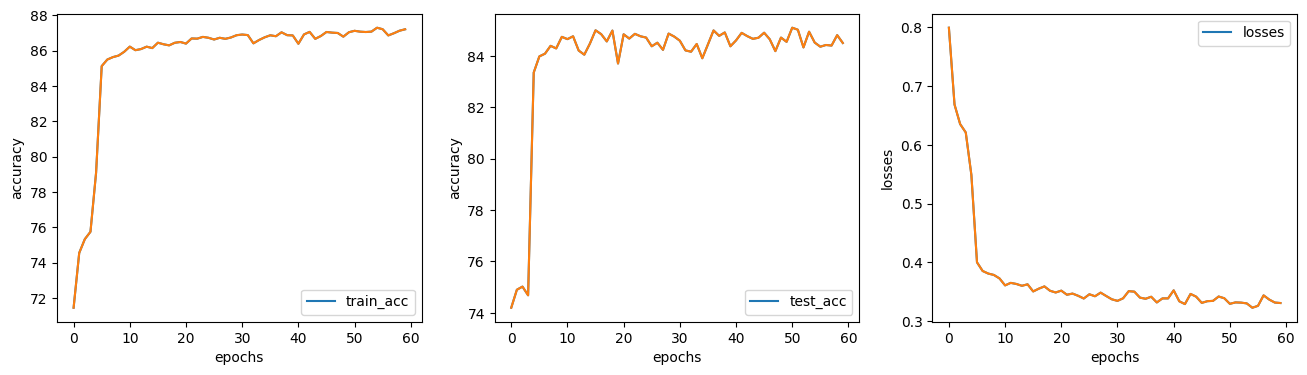

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].plot(range(epochs), train_acc)
ax[0].plot(range(epochs), train_acc)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train_acc'])

ax[1].plot(range(epochs), test_acc)
ax[1].plot(range(epochs), test_acc)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(['test_acc'])


ax[2].plot(range(epochs), losses)
ax[2].plot(range(epochs), losses)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('losses')
ax[2].legend(['losses'])

## Inspecting the results

In [55]:
x, y = next(iter(test_loader))
preds = net(x)

In [56]:
preds.detach()

tensor([[-2.3026e+00, -2.3026e+00, -2.3026e+00,  ..., -2.3026e+00,
         -2.3026e+00, -2.3026e+00],
        [-4.1403e+01, -4.1403e+01, -4.1403e+01,  ..., -4.1403e+01,
         -3.8506e+01, -4.1403e+01],
        [-2.3026e+00, -2.3026e+00, -2.3026e+00,  ..., -2.3026e+00,
         -2.3026e+00, -2.3026e+00],
        ...,
        [ 0.0000e+00, -2.5681e+01, -2.5681e+01,  ..., -2.5681e+01,
         -2.5681e+01, -2.5681e+01],
        [ 0.0000e+00, -7.6475e+01, -7.6475e+01,  ..., -7.6475e+01,
         -7.6475e+01, -7.6475e+01],
        [-1.6412e+01, -1.6412e+01, -1.6412e+01,  ..., -1.6412e+01,
         -9.5367e-07, -1.6412e+01]])

In [57]:
torch.exp(preds.detach())

tensor([[1.0000e-01, 1.0000e-01, 1.0000e-01,  ..., 1.0000e-01, 1.0000e-01,
         1.0000e-01],
        [1.0441e-18, 1.0441e-18, 1.0441e-18,  ..., 1.0441e-18, 1.8926e-17,
         1.0441e-18],
        [1.0000e-01, 1.0000e-01, 1.0000e-01,  ..., 1.0000e-01, 1.0000e-01,
         1.0000e-01],
        ...,
        [1.0000e+00, 7.0295e-12, 7.0295e-12,  ..., 7.0295e-12, 7.0295e-12,
         7.0295e-12],
        [1.0000e+00, 6.1311e-34, 6.1311e-34,  ..., 6.1311e-34, 6.1311e-34,
         6.1311e-34],
        [7.4563e-08, 7.4563e-08, 7.4563e-08,  ..., 7.4563e-08, 1.0000e+00,
         7.4563e-08]])

In [58]:
torch.max(preds.detach(), axis=1)

torch.return_types.max(
values=tensor([-2.3026e+00,  0.0000e+00, -2.3026e+00,  ...,  0.0000e+00,
         0.0000e+00, -9.5367e-07]),
indices=tensor([0, 4, 0,  ..., 0, 0, 8]))

In [59]:
torch.max(torch.exp(preds.detach()), axis=1)

torch.return_types.max(
values=tensor([0.1000, 1.0000, 0.1000,  ..., 1.0000, 1.0000, 1.0000]),
indices=tensor([0, 4, 0,  ..., 0, 0, 8]))

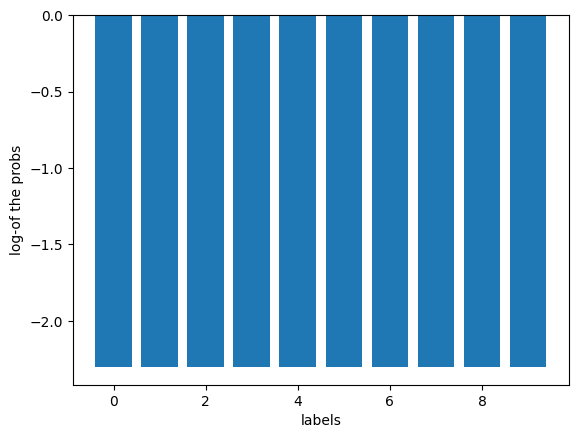

In [60]:
plt.bar(range(10), preds.detach()[0])
plt.xlabel('labels')
plt.ylabel('log-of the probs')
plt.show()

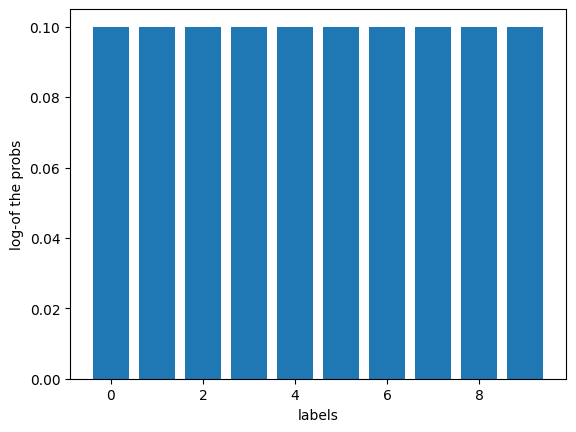

In [61]:
plt.bar(range(10), torch.exp(preds.detach())[0])
plt.xlabel('labels')
plt.ylabel('log-of the probs')
plt.show()

In [62]:
np.where(torch.argmax(preds, axis=1) != y)

(array([    0,     2,     9, ..., 17977, 17982, 17984]),)

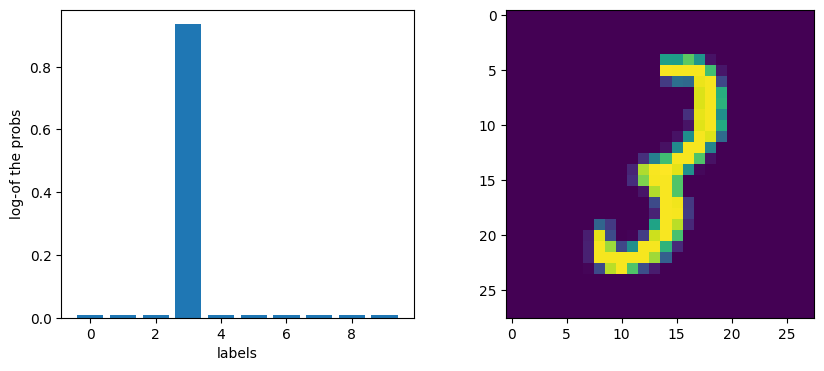

In [63]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].bar(range(10), torch.exp(preds.detach())[4])
ax[0].set_xlabel('labels')
ax[0].set_ylabel('log-of the probs')

ax[1].imshow(np.reshape(x[4,:], (28,28)))
